Step 1: Import modules

In [8]:
# Standard libraries
import sys
import os

# Add project root to sys.path
project_root = os.path.abspath("..")  # go up one level from notebooks/
sys.path.append(project_root)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

# Import functions from modular script
from src.proxy_target import calculate_rfm, label_high_risk_customers, save_rfm

# Optional: display all columns
pd.set_option('display.max_columns', None)

Step 2: Load raw Data

In [9]:
# Load the raw transaction data
raw_df = pd.read_csv('../data/raw/raw_data.csv')  # if notebook is in 'notebooks/'


print("Raw data shape:", raw_df.shape)
raw_df.head()

Raw data shape: (95662, 16)


,TransactionId,BatchId,AccountId,SubscriptionId,CustomerId,CurrencyCode,CountryCode,ProviderId,ProductId,ProductCategory,ChannelId,Amount,Value,TransactionStartTime,PricingStrategy,FraudResult
0,TransactionId_76871,BatchId_36123,AccountId_3957,SubscriptionId_887,CustomerId_4406,UGX,256,ProviderId_6,ProductId_10,airtime,ChannelId_3,1000.0,1000,2018-11-15T02:18:49Z,2,0
1,TransactionId_73770,BatchId_15642,AccountId_4841,SubscriptionId_3829,CustomerId_4406,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-20.0,20,2018-11-15T02:19:08Z,2,0
2,TransactionId_26203,BatchId_53941,AccountId_4229,SubscriptionId_222,CustomerId_4683,UGX,256,ProviderId_6,ProductId_1,airtime,ChannelId_3,500.0,500,2018-11-15T02:44:21Z,2,0
3,TransactionId_380,BatchId_102363,AccountId_648,SubscriptionId_2185,CustomerId_988,UGX,256,ProviderId_1,ProductId_21,utility_bill,ChannelId_3,20000.0,21800,2018-11-15T03:32:55Z,2,0
4,TransactionId_28195,BatchId_38780,AccountId_4841,SubscriptionId_3829,CustomerId_988,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-644.0,644,2018-11-15T03:34:21Z,2,0


In [10]:
raw_df.head()
raw_df.info()
raw_df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95662 entries, 0 to 95661
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   TransactionId         95662 non-null  object 
 1   BatchId               95662 non-null  object 
 2   AccountId             95662 non-null  object 
 3   SubscriptionId        95662 non-null  object 
 4   CustomerId            95662 non-null  object 
 5   CurrencyCode          95662 non-null  object 
 6   CountryCode           95662 non-null  int64  
 7   ProviderId            95662 non-null  object 
 8   ProductId             95662 non-null  object 
 9   ProductCategory       95662 non-null  object 
 10  ChannelId             95662 non-null  object 
 11  Amount                95662 non-null  float64
 12  Value                 95662 non-null  int64  
 13  TransactionStartTime  95662 non-null  object 
 14  PricingStrategy       95662 non-null  int64  
 15  FraudResult        

,CountryCode,Amount,Value,PricingStrategy,FraudResult
count,95662.0,9.566200e+04,9.566200e+04,95662.000000,95662.000000
mean,256.0,6.717846e+03,9.900584e+03,2.255974,0.002018
std,0.0,1.233068e+05,1.231221e+05,0.732924,0.044872
min,256.0,-1.000000e+06,2.000000e+00,0.000000,0.000000
25%,256.0,-5.000000e+01,2.750000e+02,2.000000,0.000000
50%,256.0,1.000000e+03,1.000000e+03,2.000000,0.000000
75%,256.0,2.800000e+03,5.000000e+03,2.000000,0.000000
max,256.0,9.880000e+06,9.880000e+06,4.000000,1.000000


Convert TransactionStartTime to datetime

In [11]:
raw_df['TransactionStartTime'] = pd.to_datetime(raw_df['TransactionStartTime'])

Filter out negative transactions

In [12]:
raw_df = raw_df[raw_df['Amount'] > 0]

aggregate multiple transactions per customer per day to simplify RFM:

In [13]:
daily_df = raw_df.groupby(['CustomerId', raw_df['TransactionStartTime'].dt.date])['Amount'].sum().reset_index()
daily_df.rename(columns={'TransactionStartTime': 'TransactionDate', 'Amount': 'DailyAmount'}, inplace=True)

Check cleaned data

In [14]:
daily_df.info()
daily_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20829 entries, 0 to 20828
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CustomerId       20829 non-null  object 
 1   TransactionDate  20829 non-null  object 
 2   DailyAmount      20829 non-null  float64
dtypes: float64(1), object(2)
memory usage: 488.3+ KB


,CustomerId,TransactionDate,DailyAmount
0,CustomerId_1001,2018-11-16,25200.0
1,CustomerId_1002,2018-11-15,1500.0
2,CustomerId_1002,2018-11-22,500.0
3,CustomerId_1002,2018-12-09,1000.0
4,CustomerId_1002,2018-12-10,500.0


In [18]:
# Convert TransactionDate to datetime
daily_df['TransactionDate'] = pd.to_datetime(daily_df['TransactionDate'])

In [19]:
daily_df['TransactionDate'] = pd.to_datetime(daily_df['TransactionDate'])

Step 3: Define Snapshot Date

In [20]:
snapshot_date = daily_df['TransactionDate'].max() + pd.Timedelta(days=1)
print("Snapshot Date:", snapshot_date)

Snapshot Date: 2019-02-14 00:00:00


Step 4: Calculate RFM Metrics

In [21]:
# Ensure TransactionDate is datetime
daily_df['TransactionDate'] = pd.to_datetime(daily_df['TransactionDate'])

# Group by CustomerId with named aggregation
rfm_df = daily_df.groupby('CustomerId').agg(
    Recency = ('TransactionDate', lambda x: (snapshot_date - x.max()).days),
    Frequency = ('TransactionDate', 'count'),
    Monetary = ('DailyAmount', 'sum')
).reset_index()

# Inspect the RFM table
rfm_df.head()

,CustomerId,Recency,Frequency,Monetary
0,CustomerId_1001,90,1,25200.0
1,CustomerId_1002,29,5,4500.0
2,CustomerId_1003,13,1,26000.0
3,CustomerId_1004,54,1,2000.0
4,CustomerId_1005,48,1,55000.0


Combine the metrics into a binary target:

In [22]:
# Example thresholds (you can tune)
recency_thresh = 60       # days
frequency_thresh = 2      # transactions
monetary_thresh = 5000    # total amount

# Label high-risk proxy target
rfm_df['HighRisk'] = ((rfm_df['Recency'] > recency_thresh) &
                      (rfm_df['Frequency'] <= frequency_thresh) &
                      (rfm_df['Monetary'] <= monetary_thresh)).astype(int)

# Check distribution
rfm_df['HighRisk'].value_counts()

HighRisk
0    3344
1     288
Name: count, dtype: int64

In [23]:
import os

# Ensure the directory exists
os.makedirs('data/processed', exist_ok=True)

# Save the RFM + HighRisk file
rfm_df.to_csv('data/processed/rfm_highrisk.csv', index=False)
print("RFM + HighRisk saved successfully!")

RFM + HighRisk saved successfully!


Cluster Customers

           Recency  Frequency      Monetary
Cluster                                    
0        14.665480   4.467209  1.176651e+05
1         7.300319  30.108626  1.494267e+06
2        62.602811   1.936391  6.926326e+04


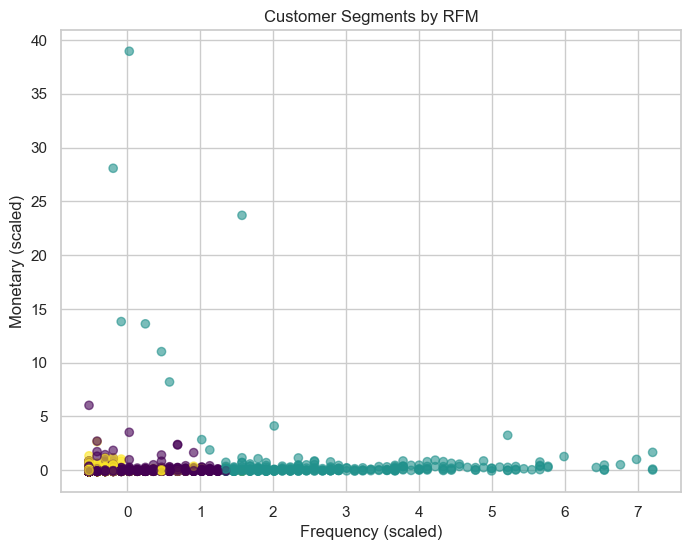

In [24]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# 1. Select RFM features
rfm_features = rfm_df[['Recency', 'Frequency', 'Monetary']]

# 2. Standardize features
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_features)

# 3. Apply K-Means clustering
kmeans = KMeans(n_clusters=3, random_state=42)
rfm_df['Cluster'] = kmeans.fit_predict(rfm_scaled)

# 4. Inspect clusters
cluster_summary = rfm_df.groupby('Cluster')[['Recency', 'Frequency', 'Monetary']].mean()
print(cluster_summary)

# 5. Optional: Visualize clusters (2D for simplicity)
import matplotlib.pyplot as plt
plt.figure(figsize=(8,6))
plt.scatter(rfm_scaled[:,1], rfm_scaled[:,2], c=rfm_df['Cluster'], cmap='viridis', alpha=0.6)
plt.xlabel('Frequency (scaled)')
plt.ylabel('Monetary (scaled)')
plt.title('Customer Segments by RFM')
plt.show()

Visualizing Clusters (RFM)

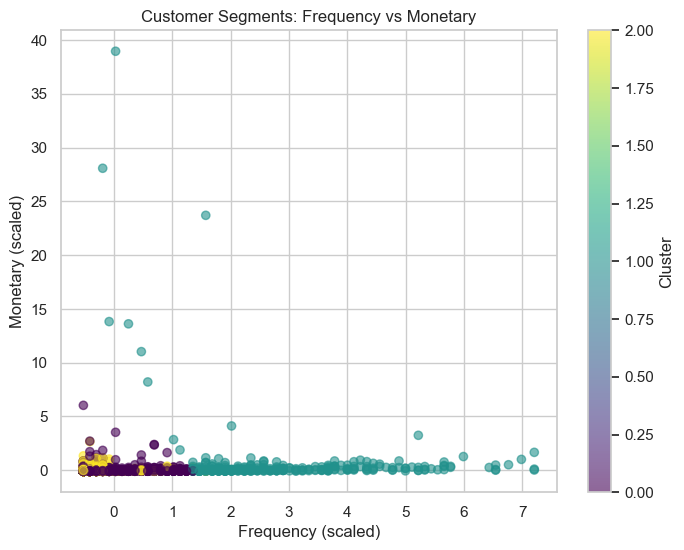

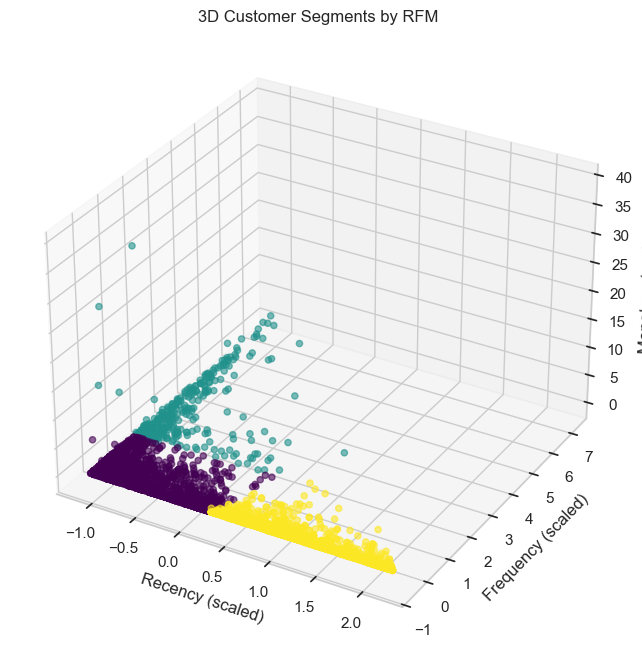

In [25]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# 2D scatter plot (Frequency vs Monetary)
plt.figure(figsize=(8,6))
plt.scatter(rfm_scaled[:,1], rfm_scaled[:,2], c=rfm_df['Cluster'], cmap='viridis', alpha=0.6)
plt.xlabel('Frequency (scaled)')
plt.ylabel('Monetary (scaled)')
plt.title('Customer Segments: Frequency vs Monetary')
plt.colorbar(label='Cluster')
plt.show()

# 3D scatter plot (Recency, Frequency, Monetary)
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(rfm_scaled[:,0], rfm_scaled[:,1], rfm_scaled[:,2], c=rfm_df['Cluster'], cmap='viridis', alpha=0.6)
ax.set_xlabel('Recency (scaled)')
ax.set_ylabel('Frequency (scaled)')
ax.set_zlabel('Monetary (scaled)')
ax.set_title('3D Customer Segments by RFM')
plt.show()

map Cluster 2 as High-Risk in the RFM dataframe.

In [26]:
# Map high-risk customers
rfm_df['HighRisk'] = rfm_df['Cluster'].apply(lambda x: 1 if x == 2 else 0)

# Count of high-risk vs others
print(rfm_df['HighRisk'].value_counts())

# Ensure the processed directory exists
import os
os.makedirs('data/processed', exist_ok=True)

# Save the RFM + HighRisk dataframe
rfm_df.to_csv('data/processed/rfm_highrisk.csv', index=False)
print("RFM + HighRisk dataset saved successfully!")

HighRisk
0    2280
1    1352
Name: count, dtype: int64
RFM + HighRisk dataset saved successfully!


Visualize Distribution Plots for Each RFM Metric

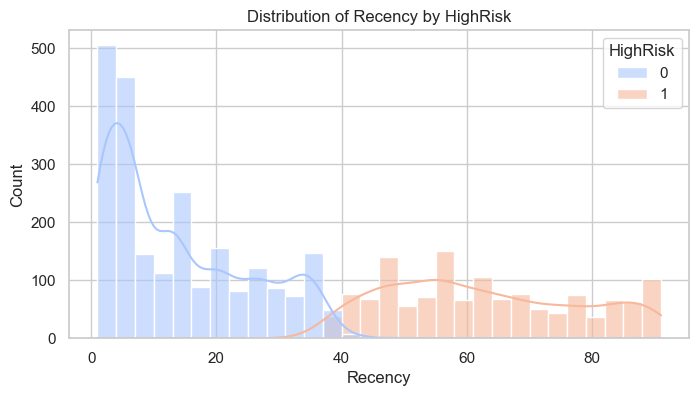

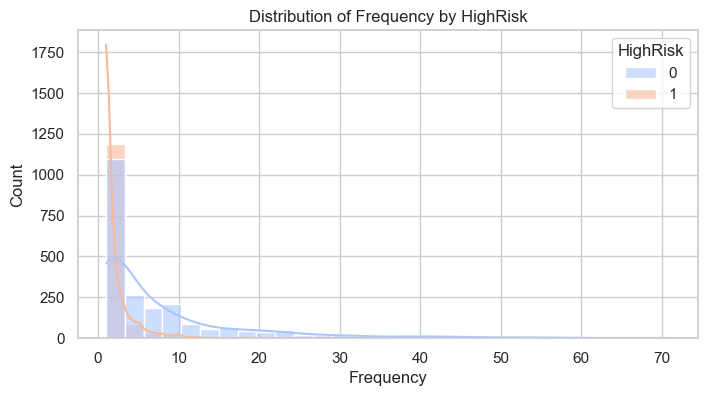

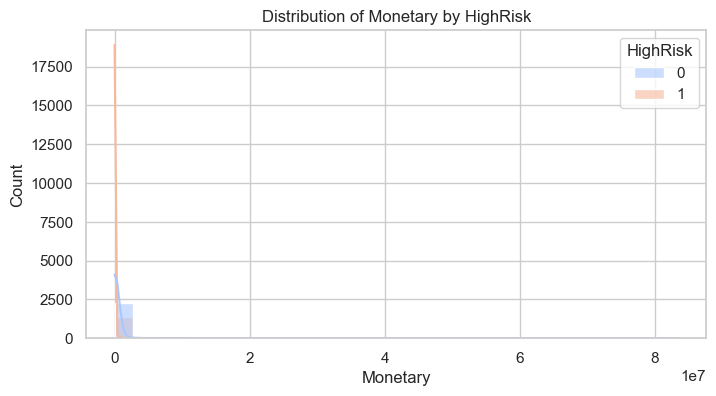

In [27]:
# Set seaborn style
sns.set(style="whitegrid")

# Metrics to visualize
rfm_metrics = ['Recency', 'Frequency', 'Monetary']

for metric in rfm_metrics:
    plt.figure(figsize=(8,4))
    sns.histplot(data=rfm_df, x=metric, hue='HighRisk', bins=30, kde=True, palette='coolwarm', alpha=0.6)
    plt.title(f'Distribution of {metric} by HighRisk')
    plt.xlabel(metric)
    plt.ylabel('Count')
    plt.show()

Boxplots to Detect Differences Between Groups

C:\Users\user\AppData\Local\Temp\ipykernel_26268\2765976228.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='HighRisk', y=metric, data=rfm_df, palette='Set2')


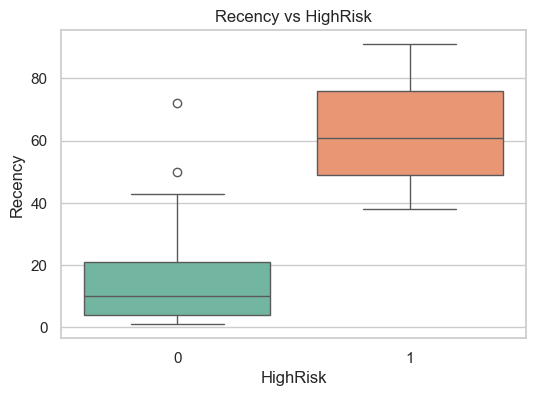

C:\Users\user\AppData\Local\Temp\ipykernel_26268\2765976228.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='HighRisk', y=metric, data=rfm_df, palette='Set2')


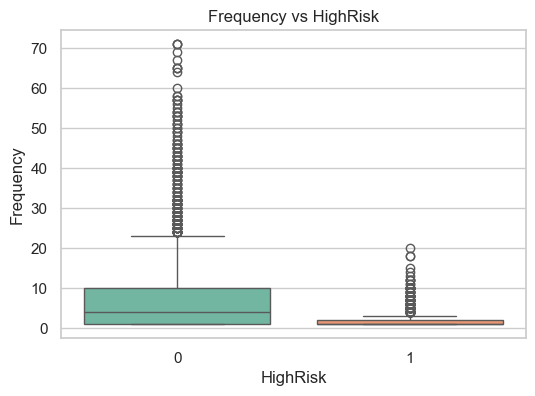

C:\Users\user\AppData\Local\Temp\ipykernel_26268\2765976228.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='HighRisk', y=metric, data=rfm_df, palette='Set2')


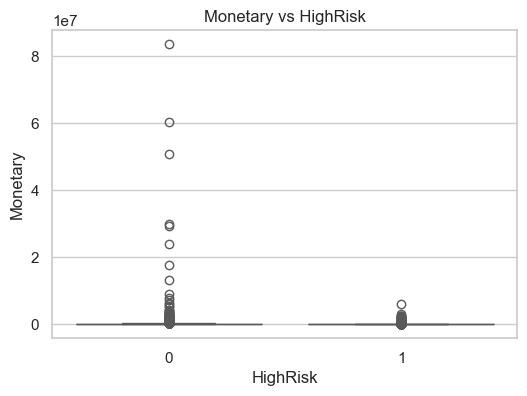

In [28]:
for metric in rfm_metrics:
    plt.figure(figsize=(6,4))
    sns.boxplot(x='HighRisk', y=metric, data=rfm_df, palette='Set2')
    plt.title(f'{metric} vs HighRisk')
    plt.show()

K-Means Clustering on RFM Metrics

In [29]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Select RFM features
rfm_features = rfm_df[['Recency', 'Frequency', 'Monetary']]

# Scale the features
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_features)

# Apply K-Means clustering
kmeans = KMeans(n_clusters=3, random_state=42)
rfm_df['Cluster'] = kmeans.fit_predict(rfm_scaled)

# Inspect cluster counts
print(rfm_df['Cluster'].value_counts())

Cluster
0    1967
2    1352
1     313
Name: count, dtype: int64


Visualize Clusters

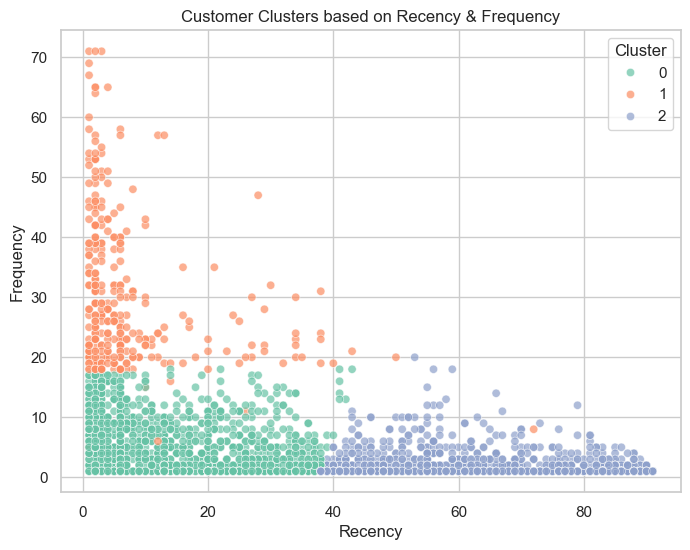

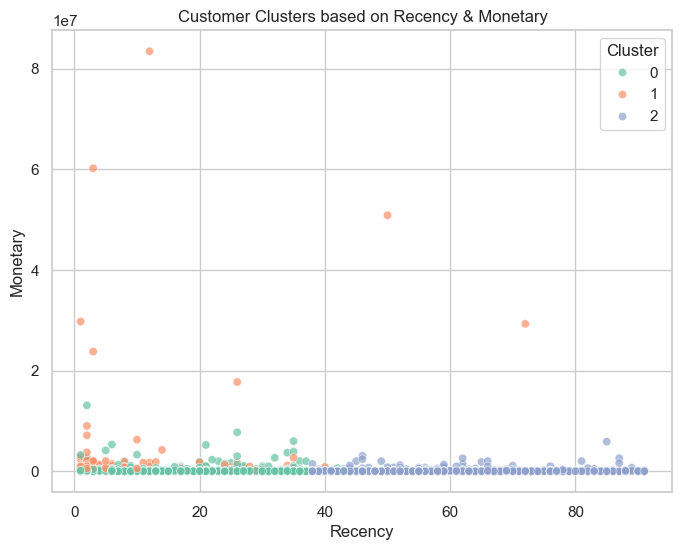

In [30]:
# Scatter plot of Recency vs Frequency colored by Cluster
plt.figure(figsize=(8,6))
sns.scatterplot(data=rfm_df, x='Recency', y='Frequency', hue='Cluster', palette='Set2', alpha=0.7)
plt.title("Customer Clusters based on Recency & Frequency")
plt.show()

# Scatter plot of Monetary vs Recency
plt.figure(figsize=(8,6))
sns.scatterplot(data=rfm_df, x='Recency', y='Monetary', hue='Cluster', palette='Set2', alpha=0.7)
plt.title("Customer Clusters based on Recency & Monetary")
plt.show()

Step 3: Define and Assign the "High-Risk" Label

In [ ]:
rfm_df.groupby('Cluster')[['Recency', 'Frequency', 'Monetary']].mean()

Create Binary Target Column

In [31]:
# Suppose cluster 0 is high-risk (replace with your actual cluster number)
high_risk_cluster = 0

rfm_df['is_high_risk'] = rfm_df['Cluster'].apply(lambda x: 1 if x == high_risk_cluster else 0)

Inspect the Distribution

In [ ]:
rfm_df['is_high_risk'].value_counts()

Save the Dataset

In [32]:
rfm_df.to_csv('data/processed/rfm_highrisk.csv', index=False)
print ("Data saved successfully")

Data saved successfully


Assign is_high_risk:

In [33]:
# Assign high-risk label
rfm_df['is_high_risk'] = rfm_df['Cluster'].apply(lambda x: 1 if x == 2 else 0)

# Check counts
print(rfm_df['is_high_risk'].value_counts())

is_high_risk
0    2280
1    1352
Name: count, dtype: int64


Visualise

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Count of high-risk vs low-risk customers
risk_counts = rfm_df['is_high_risk'].value_counts()

# Plot
plt.figure(figsize=(6,4))
sns.barplot(x=risk_counts.index, y=risk_counts.values, palette=['green','red'])
plt.xticks([0,1], ['Low-Risk (0)', 'High-Risk (1)'])
plt.ylabel('Number of Customers')
plt.title('High-Risk vs Low-Risk Customers')
plt.show()

In [ ]:
visualize the clusters in 2D RFM space

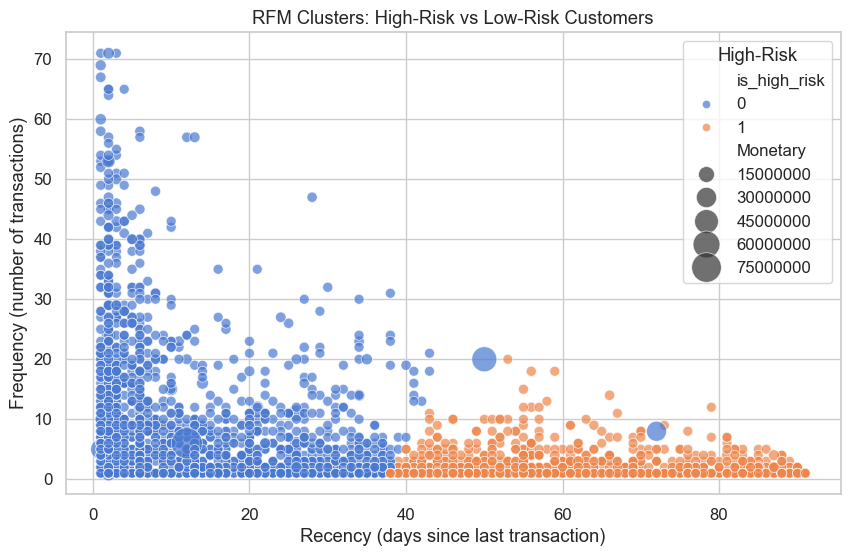

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure consistent style
sns.set(style="whitegrid", palette="muted", font_scale=1.1)

# 2D scatter plot of RFM clusters
plt.figure(figsize=(10,6))
scatter = sns.scatterplot(
    data=rfm_df, 
    x='Recency', 
    y='Frequency', 
    hue='is_high_risk',       # color by high-risk label
    size='Monetary',           # point size proportional to Monetary value
    sizes=(50, 500),           # min and max point size
    alpha=0.7
)

plt.title("RFM Clusters: High-Risk vs Low-Risk Customers")
plt.xlabel("Recency (days since last transaction)")
plt.ylabel("Frequency (number of transactions)")
plt.legend(title="High-Risk", loc='upper right')
plt.show()

4.	Integrate the Target Variable

In [35]:
# If you already added the is_high_risk column to rfm_df after clustering:
rfm_with_target = rfm_df.copy()  # just make a safe copy

# Ensure it's integer type
rfm_with_target['is_high_risk'] = rfm_with_target['is_high_risk'].astype(int)

# Inspect the first few rows
rfm_with_target.head()

,CustomerId,Recency,Frequency,Monetary,HighRisk,Cluster,is_high_risk
0,CustomerId_1001,90,1,25200.0,1,2,1
1,CustomerId_1002,29,5,4500.0,0,0,0
2,CustomerId_1003,13,1,26000.0,0,0,0
3,CustomerId_1004,54,1,2000.0,1,2,1
4,CustomerId_1005,48,1,55000.0,1,2,1


In [36]:
import os

# Make sure the folder exists
os.makedirs('../data/processed', exist_ok=True)

# Save the file
rfm_with_target.to_csv('../data/processed/rfm_model_ready.csv', index=False)

# Confirm
os.path.exists('../data/processed/rfm_model_ready.csv')

True

In [ ]:
import os
os.getcwd()